<center><h1> Cleaning Data</h1></center><br>
Missing data can be of different types: <br>
<ul>
    <li><b>Missing Completely at Random (MCAR)</b> - the propensity for a data point to be missing is completely random.<br></li>
<li><b>Missing at Random (MAR)</b> - means  the propensity for a data point to be missing is not related to the missing data, but it is related to some of the observed data.<br></li>
<li><b>Missing Not at Random (MNAR)</b> - when the missing values on a variable are related to the values of that variable itself, even after controlling for other variable</li></ul><br>
In our dataset we don't have any Missing Completely at Random variables, the color of the car could be MCAR value, but after our Exploratory Analysis we saw that some of the colors are important features of the car. MCAR variables would be the easiest ones to impute in our dataset, MCAR variables are not connected with any other variable in dataset, so I just could impute mean, median or mode values.
<br>Most of the variables are Missing at Random, we can impute them via Linear Regression impute, KNN impute, multiple imputation or Maximum likelihood imputation, this values can be predicted by other values. And as we see, we have some feature that is Missing Not at random, it is the worst case scenario, but luckily we can impute this variable too. So, this variable is "Пробег".
I will show in data itself and plot it to ensure that, this feature, indeed, is MNAR. At first, I will import everything I need. First we read the file, than drop raws with missing target values, because we will not need them. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')
from src.data_extraction import get_X_and_y, load_or_save_dataset

In [2]:
data = load_or_save_dataset.get_cleaned_outliers_dataset()

And what I do right away is, I create a new dataset, where all the samples have NaN in "Пробег" column. And from old and new dataset, I take the year column, in order to get number of cars with a certain year where "Пробег" is NaN and total number of cars. And next, I create a dataset, where first columns is quantity total number of cars each year and second column is quantity of Nan values in "Пробег" column in each year, and third column is percentage, of how many cars from total amount have blank information in "Пробег" column.

In [3]:
nulldataset= data[~data["Пробег"].notnull()]["Год выпуска"]
totaldataset = data["Год выпуска"]

In [4]:
nullval = nulldataset.value_counts()
totalval = totaldataset.value_counts()

percentage = 100.0/totalval*nullval

df =  pd.DataFrame({"All cars":totalval,"Cars with NaN":nullval,"percentage":percentage})
df

,All cars,Cars with NaN,percentage
1961.0,1,1.0,100.000000
1964.0,1,1.0,100.000000
1968.0,1,1.0,100.000000
1970.0,2,2.0,100.000000
1971.0,1,1.0,100.000000
1972.0,1,NaN,NaN
1976.0,1,1.0,100.000000
1982.0,2,2.0,100.000000
1984.0,1,1.0,100.000000
1985.0,8,7.0,87.500000


You can see yourself that people tend to not specify the mileage of the car, when the car is older. I can plot it. X is the percentage of cars with unindicated mileage as opposed to year of the car.

Text(0,0.5,'Percentage')

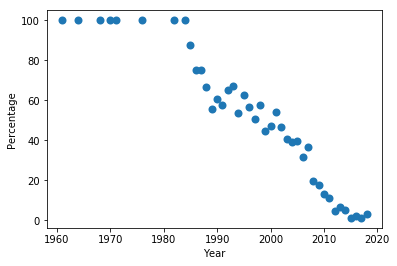

In [5]:
plt.scatter(df.index,percentage,marker="o",linewidths=2)
plt.xlabel("Year")
plt.ylabel("Percentage")

So here is the problem, I can not impute any of the missing values in the dataset by median, mean or mode, because it will definetely create bias in the model. So, I need to use more sophisticated ways of imputing, but unfortunately in scikit there is no convinient library for doing so, there is a library called "fancyimputer", but since pipinstall shows a lot of dependencies when downloading the library, I couldn't import it, because it was dependent from tensorflow library, which I couldn't download, cause it was incompetable with my system<br>
So, the solution will be to manually impute the values. Which I will do in clean_data.py. 
In the clean_data.py, I did next manipulations:
<ul>
     <li>Dropped rows with missing target values, because anyway they wouldn't really help us</li>
     <li>Dropped row "Тип кузова" because there was not a lot of missing rows with Nan in this row, so it didn't create any bias or it didn't reduce variance of model</li>
     <li>Drop year row because of the same reason, but also year is one of the most needed features, so I didn't risk to create bias, imputing this feature</li>
     <li>Imputed color feature, by making all of the unspecified samples - another class. It helps to reduce bias</li>
     <li>I did the same with fuel feature, because I was not sure if the unspecified fuel type was just unspecified, or because there were some different type of cars(electro for example), which users of webpage couldn't specify. </li>
     <li>I imputed wheel type by KNN imputation, I chose most important features for predicting the type of wheel, those features were["Цена","Тип кузова"], and I predicted the side of wheel in the car</li>
     <li>I as well imputed - ["Привод"],["КПП"],["Объём"],["Мощность"],['Пробег'] features by predicting their values by KNN machine learning algorithm, using most linearly correlated features of theirs.</li>
    <li>And, lastly, I wrote all of imputed data to new .xslx file.
</ul>
So now, you can see number of missing data from not imputed data, and you can see number of missing data from imputed data

In [6]:
data.isnull().sum()

Год выпуска      90
КПП             159
Мощность       1615
Объём           407
Привод          587
Пробег         2308
Руль            371
Тип кузова       19
Топливо         147
Цвет            563
Цена              0
dtype: int64

In [11]:
data = load_or_save_dataset.get_imputed_nans_dataset()
data.isnull().sum()

Год выпуска    0
КПП            0
Мощность       0
Объём          0
Привод         0
Пробег         0
Руль           0
Тип кузова     0
Топливо        0
Цвет           0
Цена           0
dtype: int64

Now you can see, that no missing data left, that makes for us possible using machine learning algorithms. Next thing I will do, I will create a dataset, dropping every row with missing data, from old raw data. Thus, I will see, were my hypothesis right, about biasing my datase, and we will see which model will be more accurate.


Now you will see differences between imputed and dropped data.

In [12]:
data_dropped = load_or_save_dataset.get_dropped_nans_dataset()
data_dropped.isnull().sum()

Год выпуска    0
КПП            0
Мощность       0
Объём          0
Привод         0
Пробег         0
Руль           0
Тип кузова     0
Топливо        0
Цвет           0
Цена           0
dtype: int64

You can see that both of the datasets have no missing values. But the shape as you can see below, is radically different. Dropped dataset two times smaller than imputed dataset. But sometimes it doesn't help, so I hope imputed data will make better in predictions, because imputted I nearly for 6 hours, and dropped values in 30 seconds.

In [9]:
data.shape

(7115, 11)

In [10]:
data_dropped.shape

(3504, 11)

Also, I tried to create maximum unbiased dataset, in that dataset I imputed just Missing Not At Random feature. And others I imputed a little differently.

In [13]:
data_max_unbiased = load_or_save_dataset.get_processed_dataset()

In [15]:
data_max_unbiased.shape

(6024, 10)

Next thing, I will perform is choose Dataset to perform modelling on, and after I will standartize, and make categorical features - numerical, so it will be easier for our algorithms to find optimal solution. In python there is no way to use categorical features without modifications in predictions, there are other ways in other languages, and I hope soon, those methods will be implemented in Python.